In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def whole_year_combine():
    """ Return clean and outlier trip data from separate files """
    
    clean_list = []
    outlier_list = []
    # move all the files to the current directory beforehand to get the proper file_list
    path = os.getcwd()
    file_list = [x for x in os.listdir(path) if x.startswith('2022')]

    # trimming function (0.95 quantile)
    def trimmed_095(trip_data):
        outlier_value = trip_data.groupby(['member_casual', 'rideable_type'])['trip_length_m'].transform(lambda x: x.quantile(0.95))
        df_outlier = trip_data[trip_data['trip_length_m'] > outlier_value]
        df_clean = trip_data.loc[(trip_data['trip_length_m'] > 0) & (trip_data['trip_length_m'] <= outlier_value)].copy(deep=True)
        return df_clean, df_outlier
    
    for file in file_list:
        #prepare data
        df = pd.read_csv(file, parse_dates=['started_at', 'ended_at'])
        df.drop_duplicates(inplace=True)
        df.dropna(subset=['started_at', 'ended_at'], inplace=True)
        df[['rideable_type', 'member_casual']] = df[['rideable_type', 'member_casual']].astype('category')
        df['trip_length_m'] = (df['ended_at'] - df['started_at']).astype('timedelta64[s]') / 60
        df = df.reindex(columns=['rideable_type', 'member_casual', 'started_at', 'trip_length_m'])
        df.sort_values(by='started_at', ascending=True, inplace=True)

        #remove outliers and invalid values
        df_clean, df_outlier = trimmed_095(df)

        # add dataframes to their respective lists
        clean_list.append(df_clean)
        outlier_list.append(df_outlier)
    
    # merge 12 months to create a full year view 
    trip_clean = pd.concat(clean_list, ignore_index=True)
    trip_outlier = pd.concat(outlier_list, ignore_index=True)

    # output data to .csv files
    trip_clean.to_csv('tripdata_clean_2022.csv', index=False)
    trip_outlier.to_csv('tripdata_outlier_2022.csv', index=False)
    
    return trip_clean, trip_outlier

In [4]:
trip_clean, trip_outlier = whole_year_combine()

In [5]:
# Print a summary of data
print('Clean data\n================================')
trip_clean.info(show_counts=True)
print('\nOutlier data\n================================')
trip_outlier.info(show_counts=True)

Clean data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5383945 entries, 0 to 5383944
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   rideable_type  5383945 non-null  category      
 1   member_casual  5383945 non-null  category      
 2   started_at     5383945 non-null  datetime64[ns]
 3   trip_length_m  5383945 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1)
memory usage: 92.4 MB

Outlier data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283241 entries, 0 to 283240
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   rideable_type  283241 non-null  category      
 1   member_casual  283241 non-null  category      
 2   started_at     283241 non-null  datetime64[ns]
 3   trip_length_m  283241 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1)

,count,mean,std,min,25%,50%,75%,max
trip_length_m,5383945.0,13.070128,12.175852,0.016667,5.633333,9.75,16.683333,175.9


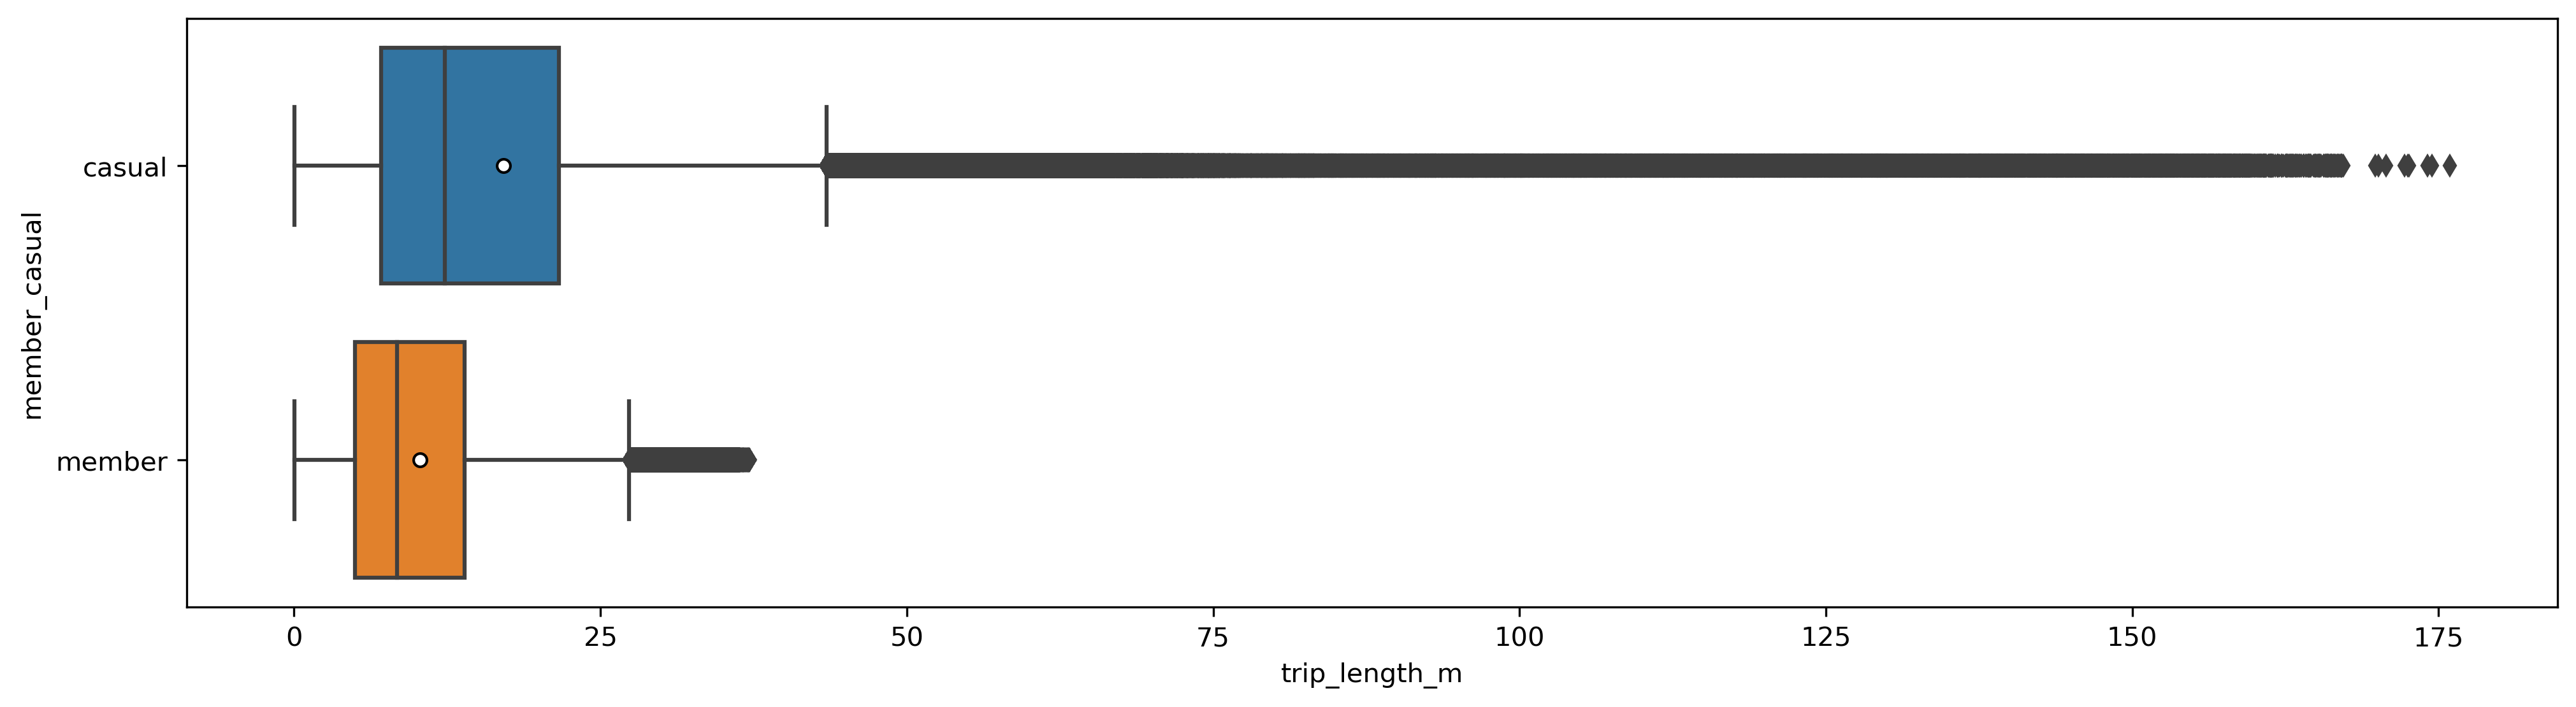

In [6]:
# descriptive summary of trip length
display(trip_clean.describe().T)

# boxplots of trip length between casual and member for clean data
plt.figure(figsize=(16,4)).set_dpi(300)
ax = sns.boxplot(data=trip_clean, x = 'trip_length_m', y='member_casual', showmeans=True, meanprops={'marker': 'o', "markerfacecolor": "white", "markeredgecolor": "black", "markersize":"5"})
plt.show()

,count,mean,std,min,25%,50%,75%,max
trip_length_m,283241.0,140.66943,775.934321,23.716667,38.566667,51.1,85.366667,41387.25


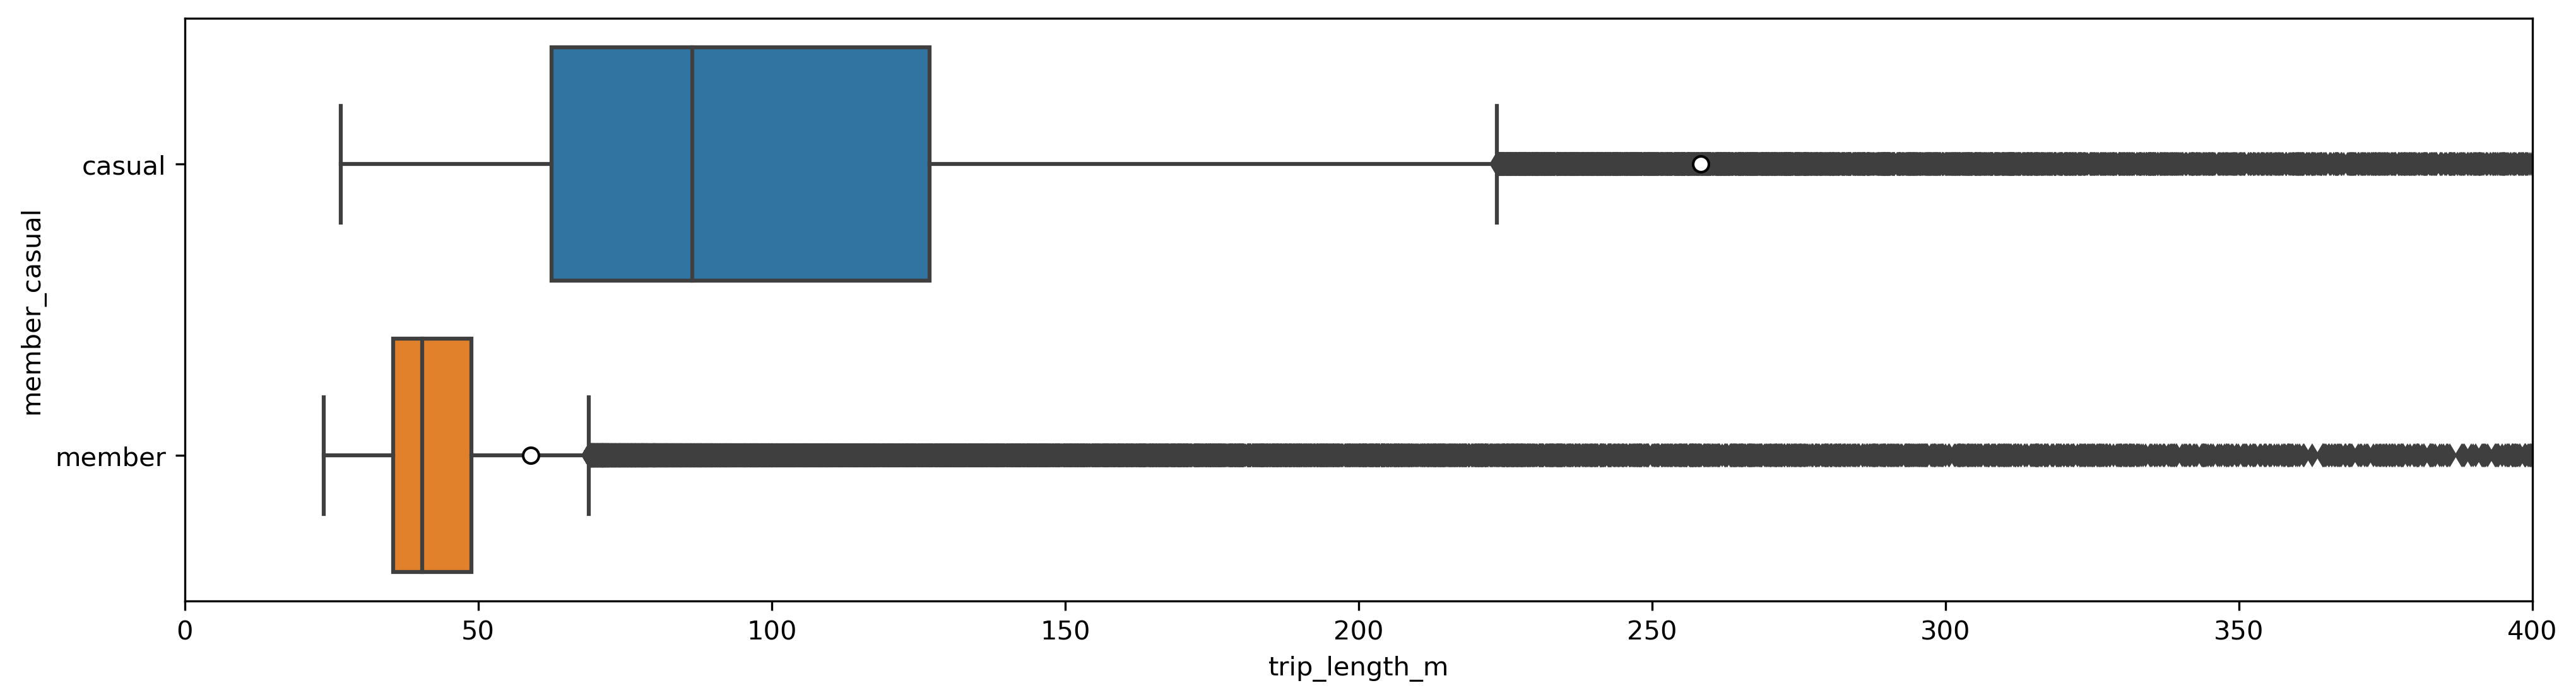

In [7]:
# descriptive summary of trip length for outliers
display(trip_outlier.describe().T)

# boxplots of trip length between casual and member for outliers
plt.figure(figsize=(16,4)).set_dpi(300)
ax = sns.boxplot(data=trip_outlier, x = 'trip_length_m', y='member_casual', showmeans=True, meanprops={'marker': 'o', "markerfacecolor": "white", "markeredgecolor": "black", "markersize":"6"})
ax.set_xbound( lower=0, upper=400)
plt.show()

# Total Trips Analysis
---

In [9]:
# descriptive statistics for 2022 data (clean + outliers)
trip_full = pd.concat([trip_clean, trip_outlier])
trip_full.describe(percentiles=[0.25, 0.5, 0.75, 0.95]).round(1).T

,count,mean,std,min,25%,50%,75%,95%,max
trip_length_m,5667186.0,19.4,176.1,0.0,5.8,10.3,18.5,45.4,41387.2


member_casual,casual,member
total_trips,2321769,3345417


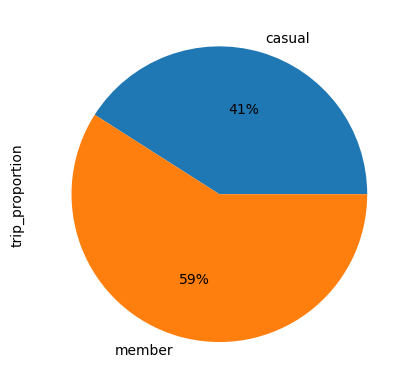

In [26]:
# Compare the trips proportion of member and casual
member_casual_trip_proportion = trip_full.groupby('member_casual').size()
display(member_casual_trip_proportion.to_frame(name='total_trips').T)

# visulization
member_casual_trip_proportion.plot(kind='pie', y=0, autopct='%1.0f%%', legend=False, ylabel='trip_proportion')
plt.show()

rideable_type,classic_bike,docked_bike,electric_bike
member_casual,,,
casual,891406,177468,1252895
member,1709682,0,1635735


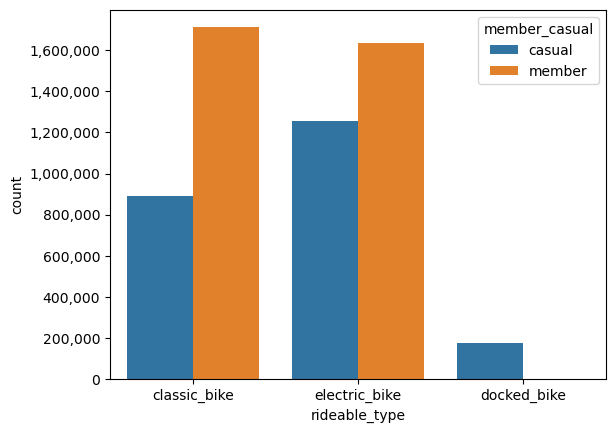

In [9]:
# total trips betwen casual and member by bike type
total_trip_by_customer_vs_bike_type = trip_full.groupby(['member_casual', 'rideable_type']).size().unstack()
display(total_trip_by_customer_vs_bike_type)

#visualization
ax = sns.countplot(data=trip_full, x='rideable_type', hue='member_casual', order=['classic_bike', 'electric_bike', 'docked_bike'])
ax.yaxis.set_major_formatter('{x:,.0f}')
plt.show()

member_casual,casual,member
hour,,
0,44608,34446
1,28826,21142
2,17875,12240
3,10659,7616
4,7343,8395
...,...,...
19,145452,195859
20,107590,137944
21,92544,108686


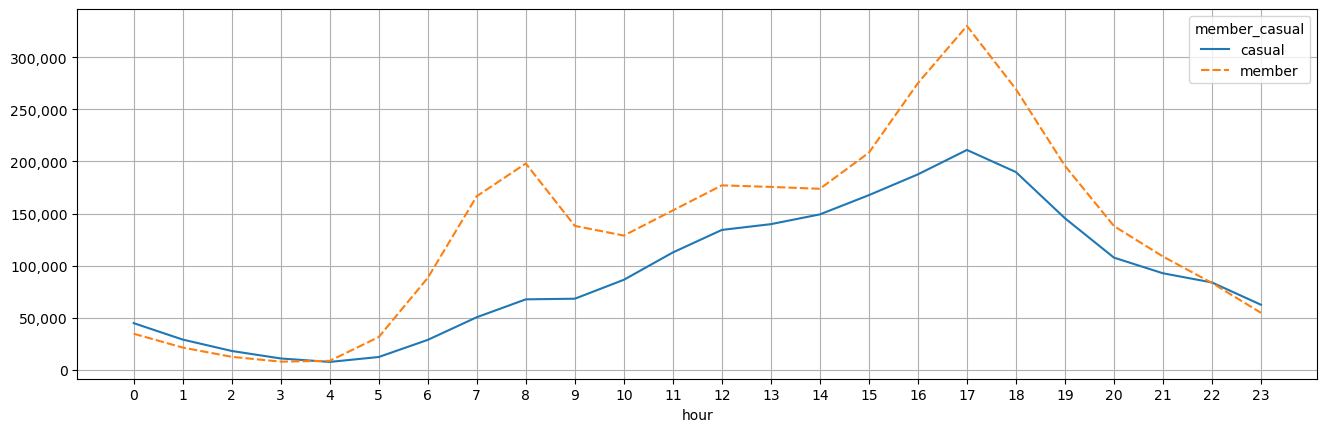

In [10]:
# set dataframe display option
frame_display = pd.option_context('display.max_rows', 10)

# total trips betwen casual and member by hour
total_trip_by_customer_vs_hour = trip_clean.groupby([trip_clean['started_at'].dt.hour, 'member_casual']).size().unstack()
total_trip_by_customer_vs_hour.index.name = 'hour'
with frame_display:
    display(total_trip_by_customer_vs_hour)

# visualization
plt.figure().set_figwidth(16)
ax = sns.lineplot(total_trip_by_customer_vs_hour)
ax.set_xticks(np.arange(24))
ax.yaxis.set_major_formatter('{x:,.0f}')
plt.grid()
plt.show()

member_casual,casual,member
day_of_week,,
Thursday,296828,508738
Friday,319520,444953
Saturday,444643,413768
Sunday,364570,361148
Monday,263153,451320
Tuesday,252894,496936
Wednesday,264079,501395


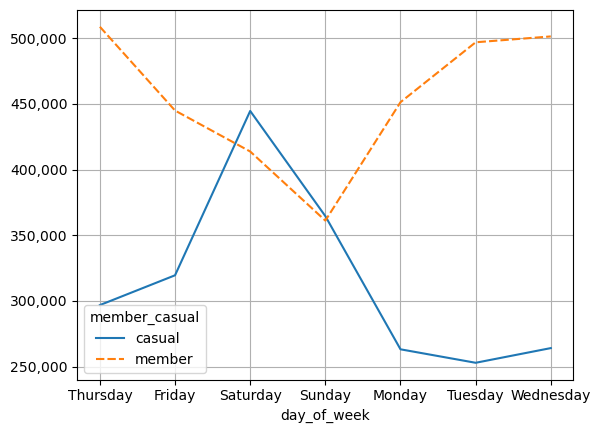

In [11]:
# total trips betwen casual and member by day of week
total_trip_by_customer_vs_DoW = trip_clean.groupby([trip_clean['started_at'].dt.day_of_week, 'member_casual']).size().unstack()
weekday_mapper = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
total_trip_by_customer_vs_DoW.index = total_trip_by_customer_vs_DoW.index.map(weekday_mapper)

DoW_order = ['Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday']
total_trip_by_customer_vs_DoW = total_trip_by_customer_vs_DoW.reindex(index=DoW_order)
total_trip_by_customer_vs_DoW.index.name = 'day_of_week'
display(total_trip_by_customer_vs_DoW)

#visualization
ax = sns.lineplot(total_trip_by_customer_vs_DoW)
ax.yaxis.set_major_formatter('{x:,.0f}')
plt.grid()
plt.show()

member_casual,casual,member,casual_sma_7,member_sma_7
date,,,,
2022-01-01,1035,1388,NaN,NaN
2022-01-02,502,1405,NaN,NaN
2022-01-03,504,2468,NaN,NaN
2022-01-04,657,3486,NaN,NaN
2022-01-05,401,2199,NaN,NaN
...,...,...,...,...
2022-12-27,418,1766,400.000000,1453.857143
2022-12-28,840,2997,322.571429,1215.857143
2022-12-29,1666,4213,483.857143,1541.142857


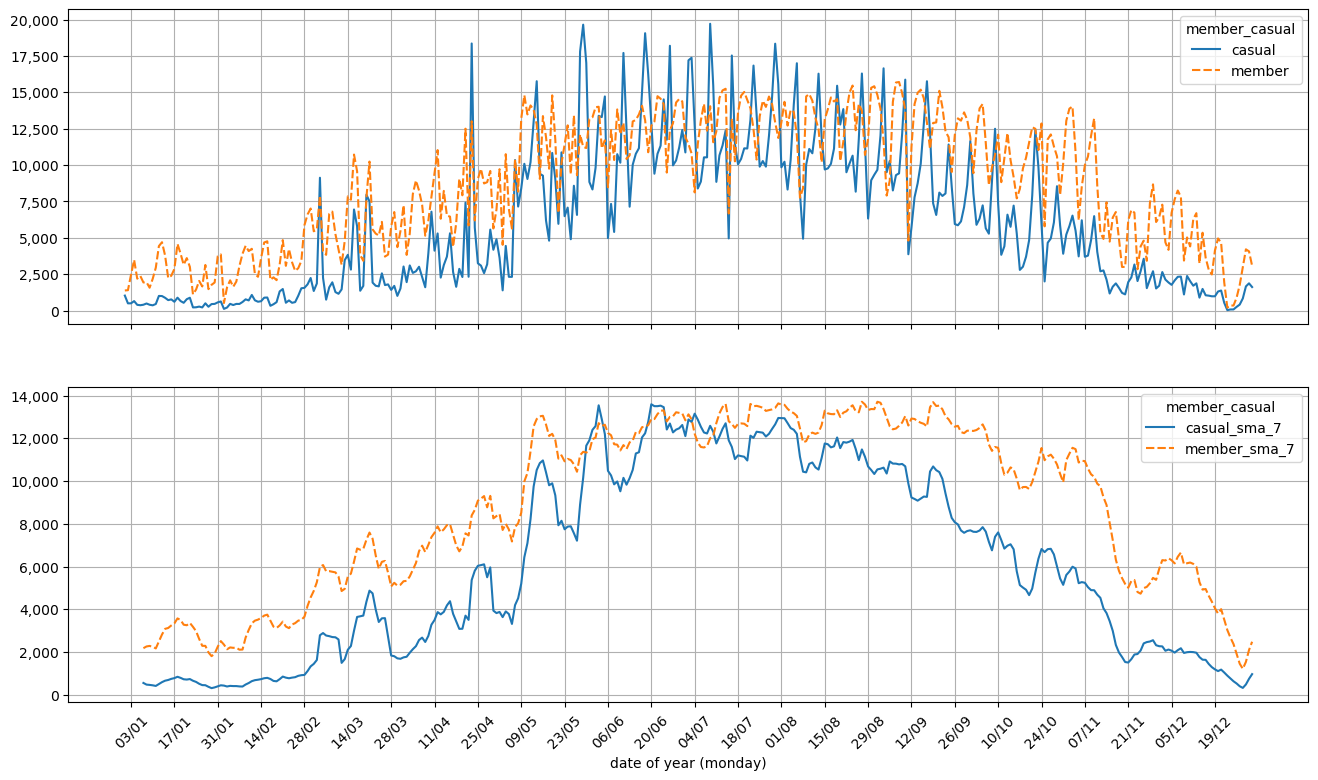

In [13]:
# daily trips betwen casual and member in 2022
total_trip_by_customer_daily = trip_clean.set_index('started_at').groupby([pd.Grouper(freq='D'), 'member_casual']).size().unstack()
total_trip_by_customer_daily.index.name = 'date'
total_trip_by_customer_daily['casual_sma_7'] = total_trip_by_customer_daily['casual'].rolling(7).mean()
total_trip_by_customer_daily['member_sma_7'] = total_trip_by_customer_daily['member'].rolling(7).mean()
with frame_display:
    display(total_trip_by_customer_daily)

# visualization
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex='col', figsize=(16,9))

# daily
sns.lineplot(total_trip_by_customer_daily[['casual', 'member']], ax=ax1)
monday_range = pd.date_range(start='2022-01-01', end='2022-12-31', freq='W-MON')[::2]
ax1.set_xticks(monday_range)
ax1.set_xticklabels(monday_range.to_series().dt.strftime('%d/%m').to_numpy())
ax1.yaxis.set_major_formatter('{x:,.0f}')
ax1.grid()

#daily using simple moving average of 7 days
sns.lineplot(total_trip_by_customer_daily[['casual_sma_7', 'member_sma_7']], ax=ax2)
ax2.yaxis.set_major_formatter('{x:,.0f}')
ax2.set_xlabel('date of year (monday)')
ax2.grid()
plt.xticks(rotation=45)
plt.show()

member_casual,casual,member
month,,
1,17591,80989
2,20343,89482
3,85379,184445
4,120076,232583
5,266369,336713
...,...,...
8,340941,405637
9,281835,384399
10,198514,332183


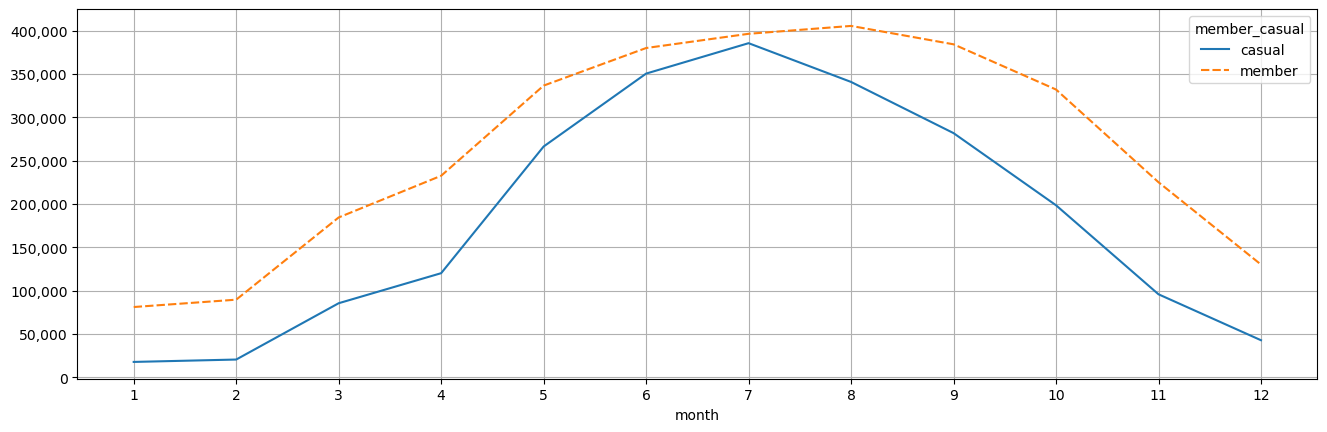

In [14]:
# monthly trips betwen casual and member in 2022
total_trip_by_customer_monthly = trip_clean.groupby([trip_clean['started_at'].dt.month, 'member_casual']).size().unstack()
total_trip_by_customer_monthly.index.name = 'month'
with frame_display:
    display(total_trip_by_customer_monthly)

# visualization
plt.figure().set_figwidth(16)
ax = sns.lineplot(total_trip_by_customer_monthly)
ax.set_xticks(np.arange(1, 13))
ax.yaxis.set_major_formatter('{x:,.0f}')
plt.grid()
plt.show()

# Average Trip Length Analysis
---

In [15]:
# Compare average trip length of member and casual
member_casual_avg_length = trip_clean.groupby('member_casual')['trip_length_m'].mean().to_frame()
display(member_casual_avg_length.T)

member_casual,casual,member
trip_length_m,17.088836,10.281175


rideable_type,classic_bike,docked_bike,electric_bike
member_casual,,,
casual,18.518658,37.737168,13.146858
member,11.039308,NaN,9.488767


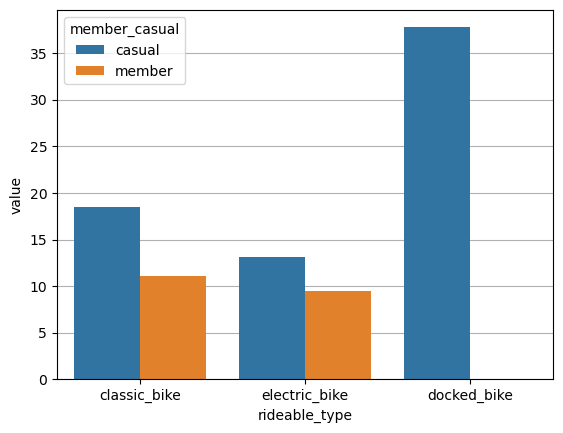

In [26]:
# avg trip length betwen casual and member by bike type
avg_length_by_customer_vs_bike_type = trip_clean.groupby(['member_casual', 'rideable_type'])['trip_length_m'].mean().unstack()
display(avg_length_by_customer_vs_bike_type)

#visualization
avg_bike_type_reshaped = pd.melt(avg_length_by_customer_vs_bike_type.reset_index(), id_vars='member_casual')
ax = sns.barplot(data=avg_bike_type_reshaped, x='rideable_type', y = 'value', hue='member_casual', order=['classic_bike', 'electric_bike', 'docked_bike'], errorbar=None)
ax.grid(axis='y')
ax.set_axisbelow(True)
plt.show()

member_casual,casual,member
hour,,
0,14.206422,9.806754
1,14.275116,9.681464
2,14.376375,9.656178
3,13.800787,9.474915
4,13.095529,9.747667
...,...,...
19,16.379030,10.601074
20,16.122964,10.501910
21,15.429273,10.387068


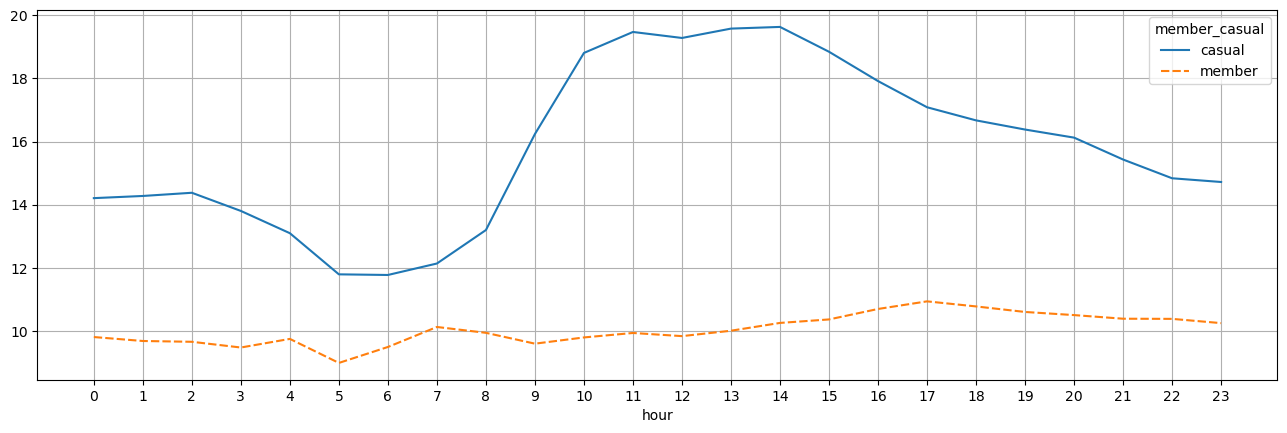

In [27]:
# avg trip length betwen casual and member by hour
avg_length_by_customer_vs_hour = trip_clean.groupby([trip_clean['started_at'].dt.hour, 'member_casual'])['trip_length_m'].mean().unstack()
avg_length_by_customer_vs_hour.index.name = 'hour'
with frame_display:
    display(avg_length_by_customer_vs_hour)

# visualization
plt.figure().set_figwidth(16)
ax = sns.lineplot(avg_length_by_customer_vs_hour)
ax.set_xticks(np.arange(24))
plt.grid()
plt.show()

member_casual,casual,member
day_of_week,,
Thursday,15.570401,10.132781
Friday,16.227454,10.175451
Saturday,18.906760,11.013014
Sunday,19.094006,10.856775
Monday,17.334968,9.989243
Tuesday,15.536631,9.988340
Wednesday,15.249855,10.060034


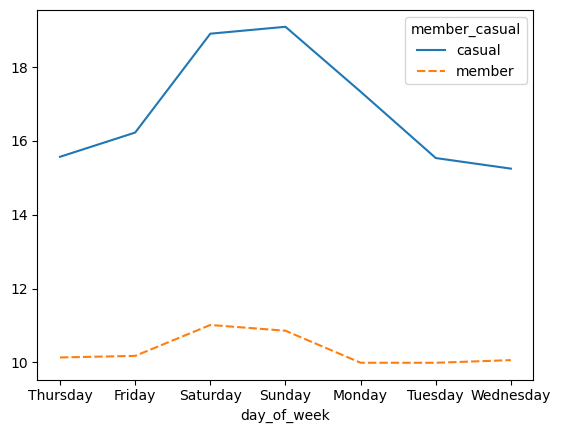

In [28]:
# avg trip length betwen casual and member by day of week
avg_length_by_customer_vs_DoW = trip_clean.groupby([trip_clean['started_at'].dt.day_of_week, 'member_casual'])['trip_length_m'].mean().unstack()
weekday_mapper = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
avg_length_by_customer_vs_DoW.index = avg_length_by_customer_vs_DoW.index.map(weekday_mapper)

DoW_order = ['Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday']
avg_length_by_customer_vs_DoW = avg_length_by_customer_vs_DoW.reindex(index=DoW_order)
avg_length_by_customer_vs_DoW.index.name = 'day_of_week'
display(avg_length_by_customer_vs_DoW)

# visualization
sns.lineplot(avg_length_by_customer_vs_DoW)
plt.show()

member_casual,casual,member
day_of_year,,
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
...,...,...
361,10.005752,8.513762
362,10.146019,8.588921
363,10.620436,8.694999


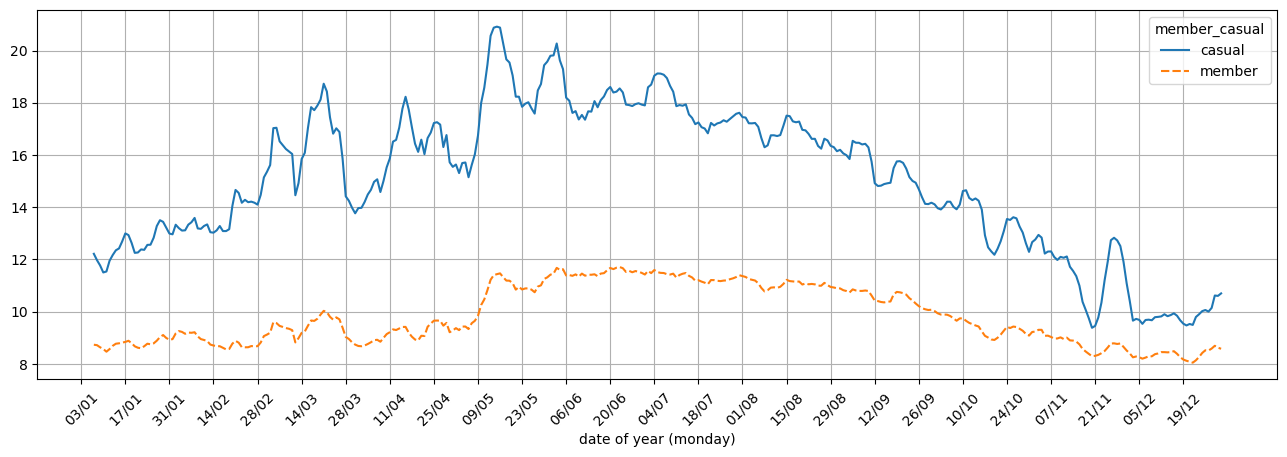

In [29]:
# avg trip length betwen casual and member by day of year (SMA7)
avg_length_by_customer_vs_DoY = trip_clean.groupby([trip_clean['started_at'].dt.day_of_year, 'member_casual'])['trip_length_m'].mean().unstack()
avg_length_by_customer_vs_DoY = avg_length_by_customer_vs_DoY.transform(lambda x: x.rolling(7).mean())
avg_length_by_customer_vs_DoY.index.name = 'day_of_year'
display(avg_length_by_customer_vs_DoY)

# visualization
plt.figure().set_figwidth(16)
ax = sns.lineplot(avg_length_by_customer_vs_DoY)
ax.set_xticks(np.arange(3,366,7)[::2])
monday_range = pd.date_range(start='2022-01-01', end='2022-12-31', freq='W-MON')[::2]
ax.set_xticklabels(monday_range.to_series().dt.strftime('%d/%m').to_numpy())
ax.set_xlabel('date of year (monday)')
plt.grid()
plt.xticks(rotation=45)
plt.show()

member_casual,casual,member
month,,
1,12.702735,8.771337
2,14.488614,8.838614
3,18.621169,9.533727
4,18.052321,9.341467
5,20.012119,10.966016
...,...,...
8,16.910549,10.982462
9,15.645705,10.459890
10,14.359958,9.436010


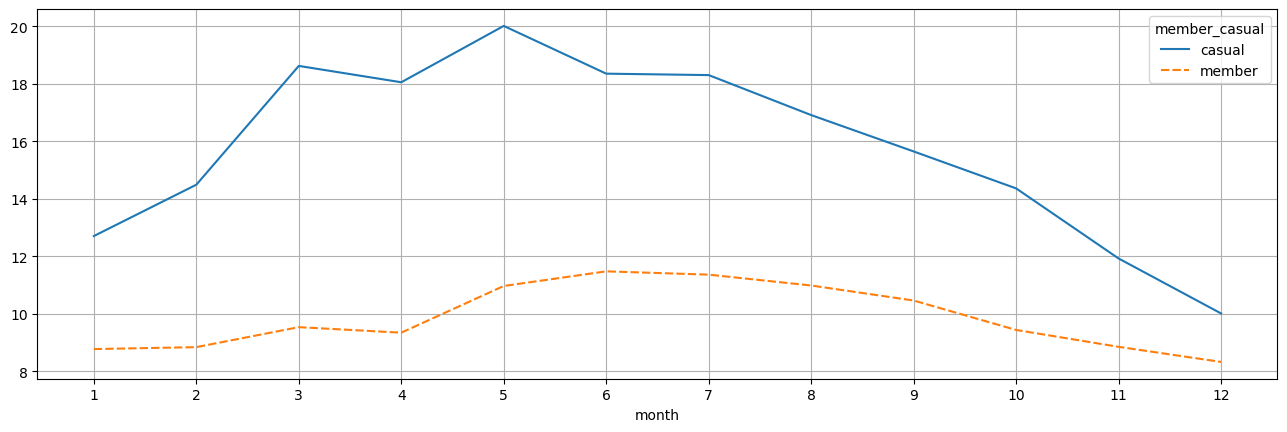

In [30]:
# avg trip length betwen casual and member by month
avg_length_by_customer_monthly = trip_clean.groupby([trip_clean['started_at'].dt.month, 'member_casual'])['trip_length_m'].mean().unstack()
avg_length_by_customer_monthly.index.name = 'month'
with frame_display:
    display(avg_length_by_customer_monthly)

# visualization
plt.figure().set_figwidth(16)
ax = sns.lineplot(avg_length_by_customer_monthly)
ax.set_xticks(np.arange(1, 13))
plt.grid()
plt.show()